# Lab 12 Spectral Analysis

# 1.1 Linear trend in CO2

Rate of increase of CO2 in Barrow: 2.49 ppm/year
Rate of increase of CO2 in Mauna Loa: 2.46 ppm/year


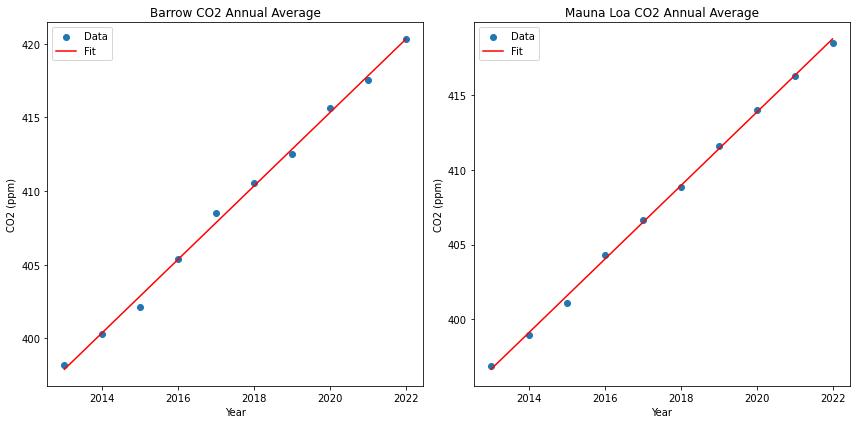

In [4]:
#a
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
barrow_data = pd.read_csv('co2_barrow_monthly_averages.txt', delim_whitespace=True, comment='#', header=None, names=['year', 'month', 'co2'])
mauna_loa_data = pd.read_csv('co2_maunaLoa_monthly_averages.txt', delim_whitespace=True, comment='#', header=None, names=['year', 'month', 'co2'])

# Filter data for the past decade
current_year = 2023
past_decade_start = current_year - 10

barrow_data_decade = barrow_data[barrow_data['year'] >= past_decade_start]
mauna_loa_data_decade = mauna_loa_data[mauna_loa_data['year'] >= past_decade_start]

# Calculate annual averages
barrow_annual_avg = barrow_data_decade.groupby('year')['co2'].mean().reset_index()
mauna_loa_annual_avg = mauna_loa_data_decade.groupby('year')['co2'].mean().reset_index()

# Linear regression
def linear_regression_rate(df):
    X = df['year'].values.reshape(-1, 1)
    y = df['co2'].values
    model = LinearRegression()
    model.fit(X, y)
    rate_of_increase = model.coef_[0]
    return rate_of_increase, model

barrow_rate, barrow_model = linear_regression_rate(barrow_annual_avg)
mauna_loa_rate, mauna_loa_model = linear_regression_rate(mauna_loa_annual_avg)

print(f"Rate of increase of CO2 in Barrow: {barrow_rate:.2f} ppm/year")
print(f"Rate of increase of CO2 in Mauna Loa: {mauna_loa_rate:.2f} ppm/year")

# Plotting 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(barrow_annual_avg['year'], barrow_annual_avg['co2'], label='Data')
plt.plot(barrow_annual_avg['year'], barrow_model.predict(barrow_annual_avg['year'].values.reshape(-1, 1)), color='red', label='Fit')
plt.title('Barrow CO2 Annual Average')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(mauna_loa_annual_avg['year'], mauna_loa_annual_avg['co2'], label='Data')
plt.plot(mauna_loa_annual_avg['year'], mauna_loa_model.predict(mauna_loa_annual_avg['year'].values.reshape(-1, 1)), color='red', label='Fit')
plt.title('Mauna Loa CO2 Annual Average')
plt.xlabel('Year')
plt.ylabel('CO2 (ppm)')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
#b
# Current CO2 levels
current_co2_barrow = barrow_annual_avg['co2'].iloc[-1]
current_co2_mauna_loa = mauna_loa_annual_avg['co2'].iloc[-1]

# Calculate the target CO2 levels (10% increase)
target_co2_barrow = current_co2_barrow * 1.10
target_co2_mauna_loa = current_co2_mauna_loa * 1.10

def predict_year_for_target(model, current_year, current_co2, target_co2):
    years_needed = (target_co2 - current_co2) / model.coef_[0]
    target_year = current_year + years_needed
    return int(target_year)

target_year_barrow = predict_year_for_target(barrow_model, current_year, current_co2_barrow, target_co2_barrow)
target_year_mauna_loa = predict_year_for_target(mauna_loa_model, current_year, current_co2_mauna_loa, target_co2_mauna_loa)

print(f"Barrow: CO2 concentration will be 10% above present day levels in the year {target_year_barrow}")
print(f"Mauna Loa: CO2 concentration will be 10% above present day levels in the year {target_year_mauna_loa}")


Barrow: CO2 concentration will be 10% above present day levels in the year 2039
Mauna Loa: CO2 concentration will be 10% above present day levels in the year 2040


# 1.2 Removing a periodic trend

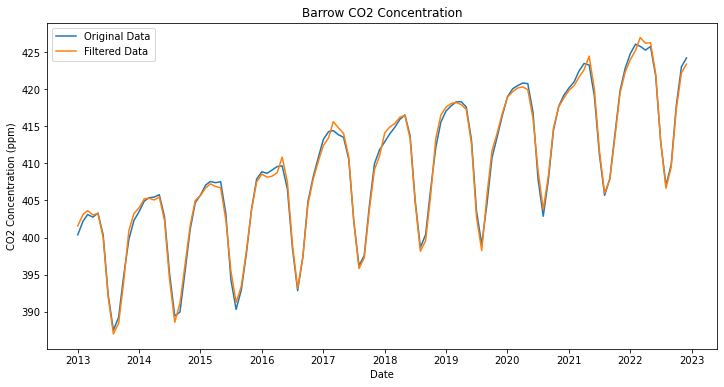

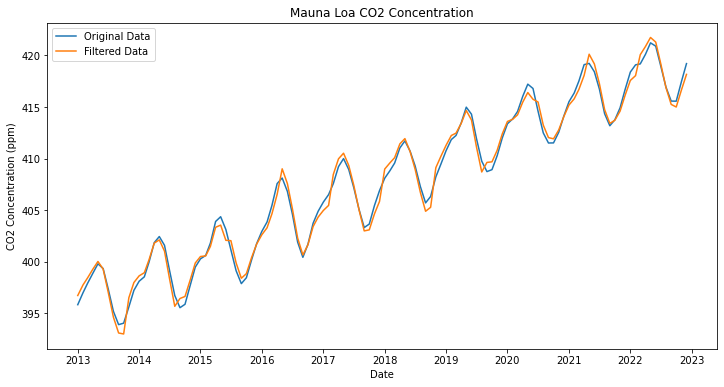

In [6]:
#a
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# Load the data
barrow_data = pd.read_csv('co2_barrow_monthly_averages.txt', delim_whitespace=True, comment='#', header=None, names=['year', 'month', 'co2'])
mauna_loa_data = pd.read_csv('co2_maunaLoa_monthly_averages.txt', delim_whitespace=True, comment='#', header=None, names=['year', 'month', 'co2'])

# Filter data for the past decade
current_year = 2023
past_decade_start = current_year - 10

barrow_data_decade = barrow_data[barrow_data['year'] >= past_decade_start]
mauna_loa_data_decade = mauna_loa_data[mauna_loa_data['year'] >= past_decade_start]

# Calculate monthly averages
barrow_monthly_avg = barrow_data_decade.groupby(['year', 'month'])['co2'].mean().reset_index()
mauna_loa_monthly_avg = mauna_loa_data_decade.groupby(['year', 'month'])['co2'].mean().reset_index()

# Convert to time series
barrow_ts = barrow_monthly_avg['co2'].values
mauna_loa_ts = mauna_loa_monthly_avg['co2'].values

# FFT and remove annual cycle
def remove_annual_cycle(ts):
    n = len(ts)
    ts_fft = fft(ts)
    ts_fft[12::12] = 0  # Zero out annual cycle and its harmonics
    ts_filtered = ifft(ts_fft)
    return np.real(ts_filtered)

barrow_filtered = remove_annual_cycle(barrow_ts)
mauna_loa_filtered = remove_annual_cycle(mauna_loa_ts)

# Plotting the results
def plot_filtered_vs_unfiltered(years, months, original, filtered, title):
    dates = pd.to_datetime({'year': years, 'month': months, 'day': 1})
    plt.figure(figsize=(12, 6))
    plt.plot(dates, original, label='Original Data')
    plt.plot(dates, filtered, label='Filtered Data')
    plt.xlabel('Date')
    plt.ylabel('CO2 Concentration (ppm)')
    plt.title(title)
    plt.legend()
    plt.show()

plot_filtered_vs_unfiltered(barrow_monthly_avg['year'], barrow_monthly_avg['month'], barrow_ts, barrow_filtered, 'Barrow CO2 Concentration')
plot_filtered_vs_unfiltered(mauna_loa_monthly_avg['year'], mauna_loa_monthly_avg['month'], mauna_loa_ts, mauna_loa_filtered, 'Mauna Loa CO2 Concentration')


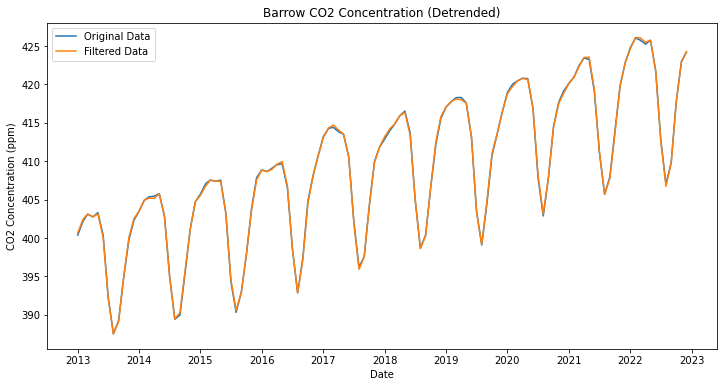

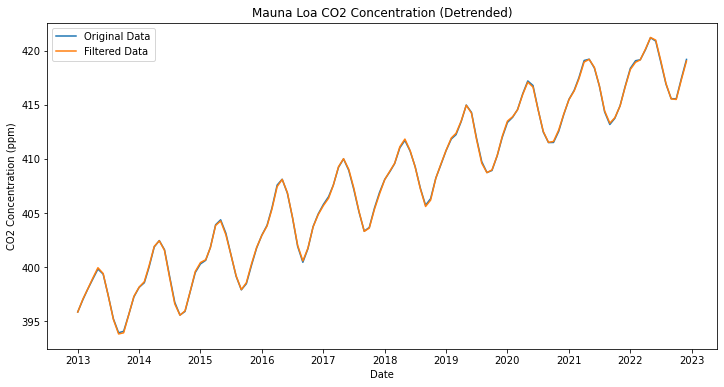

In [7]:
#b
# Function to remove linear trend
def remove_linear_trend(ts):
    X = np.arange(len(ts)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, ts)
    trend = model.predict(X)
    detrended = ts - trend
    return detrended, trend

# Function to add linear trend back
def add_linear_trend(ts, trend):
    return ts + trend

# Remove linear trend
barrow_detrended, barrow_trend = remove_linear_trend(barrow_ts)
mauna_loa_detrended, mauna_loa_trend = remove_linear_trend(mauna_loa_ts)

# Apply FFT-based filtering to detrended data
barrow_detrended_filtered = remove_annual_cycle(barrow_detrended)
mauna_loa_detrended_filtered = remove_annual_cycle(mauna_loa_detrended)

# Add linear trend back
barrow_final_filtered = add_linear_trend(barrow_detrended_filtered, barrow_trend)
mauna_loa_final_filtered = add_linear_trend(mauna_loa_detrended_filtered, mauna_loa_trend)

# Plotting the results
plot_filtered_vs_unfiltered(barrow_monthly_avg['year'], barrow_monthly_avg['month'], barrow_ts, barrow_final_filtered, 'Barrow CO2 Concentration (Detrended)')
plot_filtered_vs_unfiltered(mauna_loa_monthly_avg['year'], mauna_loa_monthly_avg['month'], mauna_loa_ts, mauna_loa_final_filtered, 'Mauna Loa CO2 Concentration (Detrended)')


In [ ]:
#Part (b) offers a more precise approach by isolating the cyclical component and 
#retaining the overall trend, leading to a more detailed understanding of both 
#short-term fluctuations and long-term trends in CO2 concentration.